# Cosmology with Supernovae Ia
The aim of this exercise is to write an MCMC code to estimate cosmological parameters from supernova
Ia data. Supernova Ia are standard candles (or can be made so), so can be used to measure the contents
of the Universe.

# Theory and parameters

The flux from a supernova of flux $L$ is given by $$f = \frac{L}{4\pi D_L^2}$$ where $D_L$ is the $Luminosity$ $Distance$. In Big Bang cosmology, it is given by $$D_L = \frac{(1+z)c}{H_0 \sqrt{|1-\Omega|} S_k(r)}$$ where $$r(z) = \sqrt{|1-\Omega|} \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + \Omega_v + (1-\Omega)(1+z')^2}}$$ and $S_k(r) = sin r, r, sinh$ $r$, depending on whether
 $\Omega \equiv \Omega_m + \Omega_v$ is $> 1$, $=1$, or $ < 1$ and $z$ is the observed redshift of the supernova. $\Omega_m, \Omega_v$ and $H_0$ are the density parameters (today) in matter, vacuum energy, and the Hubble constant. It is beyond the scope of these notes to derive this, but it is standard material for an undergraduate cosmology course.

For a flat universe ($\Omega = 1$), this simplifies to $$D_L(z) = 3000 h^{-1}(1+z) \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + 1- \Omega_m}} Mpc, $$
where $H_0 = 100h$ km $s^{-1}$ $Mpc^{-1}$. To avoid evaluating integrals to calculate $D_L$, we can use an accurate fitting formula (valid for flat universes only), given by U.-L. Pen, ApJS, 120, 49 (1999):
$$D_L(z)=\frac{c}{H_0}(1+z) \left[\eta (1,\Omega_m) -\eta (\frac{1}{1+z},\Omega_m) \right]$$
where
$$\eta(a,\Omega_m) = 2\sqrt{s^3 +1} \left[\frac{1}{a^4} - 0.1540 \frac{s}{a^3} + 0.4304\frac{s^2}{a^2} + 0.19097\frac{s^3}{a} + 0.066941 s^4 \right]^{-1/8}$$
and $s^3 \equiv (1-\Omega_m)/\Omega_m$. This is accurate to better than 0.4% for $0.2 \leq \Omega_m \leq 1$.

Fluxes are usually expressed in magnitudes, where $m = -2.5 log_{10} F +$ constant. The distance modulus is $\mu = m- M$ where $M$ is the absolute magnitude, which is the value of $m$ if the source is at a distance $10pc$. With $D_L$ in $Mpc^{1}$, this is $$\mu = 25 - 5 log_{10} h + 5 log_{10} (\frac{D_L^*}{Mpc}) $$
The Hubble constant has been factored out of $D_L: D_L^* \equiv D_L (h =1)$.

If we have measurements of $\mu$, then we can use Bayesian arguments to estimate the parameters $\Omega_m, \Omega_v,h.$ For anyone unfamiliar with cosmology, these numbers are somewhere between $0$ and $1$.

Importing neccessary libraries

In [ ]:
import numpy as np
import numpy.linalg as nplin
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.cm as cmp
import scipy.integrate as sc

Defining variables given in the question and importing the given data. The data used can be acquired from:


1.  jla_mub_0: https://github.com/Kun-Thapar/Markhov_Chain_Monte_Carlo/blob/main/jla_mub_0.txt
2.   jla_mub_covmatrix: https://github.com/Kun-Thapar/Markhov_Chain_Monte_Carlo/blob/main/jla_mub_covmatrix.txt



In [ ]:
samp = 1000                                                                            #Sampling rate
para = 2                                                                                   #Number of parameters
bins = 31                                                                                 #Number of bins
Data = open('jla_mub_0.txt', 'r')
z,myu = np.loadtxt(Data, unpack=True, usecols=[0,1])         # where z and myu observed values of redshift and distance modulus respectively
covariance = np.loadtxt('jla_mub_covmatrix.txt')                  # Reshaping
cov_matrix = np.reshape(covariance, (bins, bins))
cov_inverse = nplin.inv(cov_matrix)                                     #calculating the inverse as we have a C inverse in the likelihood formula

Here, we define the required formulas given in the question

In [ ]:

#Defining eta:
def Eta(a, Ome_m):
    if Ome_m >= 0.9999:         #value considered between 0.2 to 1
        Ome_m = 0.9999          #Given
    elif Ome_m <= 0.2:
        Ome_m = 0.2
    else:
        pass
        s = ((1.0-Ome_m)/Ome_m)**(1.0/3.0)
        eeta = 2.0*(np.sqrt((s**3.0) + 1.0))*((1.0/(a**4)) - 0.1540*(s/(a**3)) + 0.4304*((s*s)/(a*a)) + 0.19097*((s**3)/a) + 0.066941*(s**4))**(-1.0/8.0)
    return eeta

#Defining luminosity distance:
def Lum_d(z, Ome_m):
    E_1 = Eta(1, Ome_m)
    E_2 = Eta(1/(1+z), Ome_m)
    Lumin_dis = (3000.0*(1+z))*(E_1 - E_2)
    return Lumin_dis

#The distance modulus:
def myu_ith(z,Ome_m,h):
    d_L = Lum_d(z,Ome_m)
    Myu = 25 - (5*np.log10(h)) + (5*np.log10(d_L))
    return Myu

#and finally, the likelihood
difr = np.empty(bins)
def likelihood(Ome_m,h,z,myu):
    if Ome_m <= 0.0 or h <= 0.0:     #values are in between 0 to 1, so imposing this condition
        L = -1.e100
    else:
        for i in range(bins):
            difr[i] = myu[i] - myu_ith(z[i],Ome_m,h)

        Dot_1 = np.dot(cov_inverse, difr)                 # This will give a row matrix of order [1,31]
        like = -0.5*np.dot(np.transpose(difr),Dot_1)       # This gives ln(L)

    return like

Here, we create a 1 row and 3 columns empty array.
*   The first column will store omega matter values
*   the second column will store the hubble parameter values and
*   the third column will store likelihood values, All assuming from the given question that the error in the parameter is a gaussian.


In [ ]:
est_par = np.empty([samp, para+1])

Ome_sigma = 0.01              #standard deviation in the matter density parameter
hp_sigma = 0.01               #standard deviation in hubble parameter
Ome_next = 0                  #next value of matter density parameter
hp_next = 0                   #next value of hubble parameter
like_prev = 0                 #previous value of ln likelihood
Accept = 0                    #Acceptance probability of a step
like_next = 0                 #next value of ln likelihood
np.random.seed(0)
est_par[0,0] = np.random.uniform()
est_par[0,1] = np.random.uniform()
est_par[0,2] = likelihood(est_par[0,0],est_par[0,1],z,myu)  #As we defined likelihood earlier

Sampling

In [ ]:
np.random.seed(0)

for i in range(1,samp+1):
    L_pre = est_par[i-1,2]
    Omega_next = np.random.normal(est_par[i-1,0], Ome_sigma)
    h_next = np.random.normal(est_par[i-1,1],hp_sigma)
    L_next = likelihood(Omega_next,h_next,z,myu)

    if L_next >= L_pre:
        est_par[i,0] = Omega_next
        est_par[i,1] = h_next
        est_par[i,2] = L_next
        Accept = Accept + 1
        print("Step is Accepted with high likelihood")

    else:
        A = np.random.uniform()
        if (L_next-L_pre) > np.log(A):         #We take the log here since we have an exponential in the likelihood formula
            est_par[i,0] = Omega_next
            est_par[i,1] = h_next
            est_par[i,2] = L_next
            Accept = Accept + 1
            print("Step is Accepted with low likelihood")

        else:
            est_par[i,0] = est_par[i-1,0]
            est_par[i,1] = est_par[i-1,1]
            est_par[i,2] = L_pre
            print("The step is rejected")

The step is rejected
The step is rejected
The step is rejected
Step is Accepted with high likelihood
The step is rejected
The step is rejected
The step is rejected
Step is Accepted with high likelihood
Step is Accepted with low likelihood
The step is rejected
Step is Accepted with high likelihood
The step is rejected
The step is rejected
The step is rejected
The step is rejected
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with high likelihood
Step is Accepted with high likelihood
Step is Accepted with high likelihood
Step is Accepted with low likelihood
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with low likelihood
Step is Accepted with low likelihood
The step is rejected
The step is rejected
The step is rejected
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with high likeliho

IndexError: ignored

Once random sampling is produced, we plot the resulted samples

Text(0, 0.5, 'Hubble parameter')

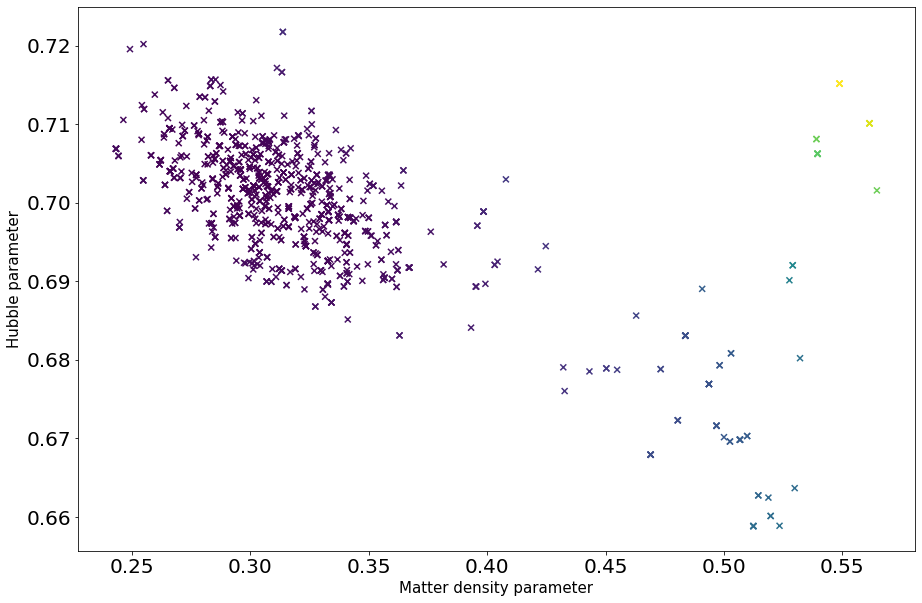

In [ ]:

plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
plt.scatter(est_par[:,0], est_par[:,1], c=-est_par[:,2], marker='x')
plt.xlabel('Matter density parameter', fontsize='15')
plt.ylabel('Hubble parameter', fontsize='15')
#plt.savefig("scattered plot.pdf")

Now, for the burn-in process, we reject some  100 samples and estimate the mean and variance of h and omega respectively.

In [ ]:
reject_samp = 100
Ome_m = np.mean(est_par[reject_samp:,0])          #Matter density parameter mean value
Ome_v = np.var(est_par[reject_samp:,0])           #Varience of the same
hp_m = np.mean(est_par[reject_samp:,1])           #hubble paramter 'h' mean value
hp_v = np.var(est_par[reject_samp:,1])            #Varience of the same

print("The estimated mean value of matter density parameter=", Ome_m)
print("Estimated variance of the same=", Ome_v)
print("The estimated mean value of the hubble parameter=",hp_m)
print("Estimated variance of the same =",hp_v)

The estimated mean value of matter density parameter= 0.30921307219322014
Estimated variance of the same= 0.0006767446880763453
The estimated mean value of the hubble parameter= 0.7011439670393381
Estimated variance of the same = 3.699922632784013e-05


Graphing a scatter plot after the burn-in process

Text(0, 0.5, 'Hubble parameter (h)')

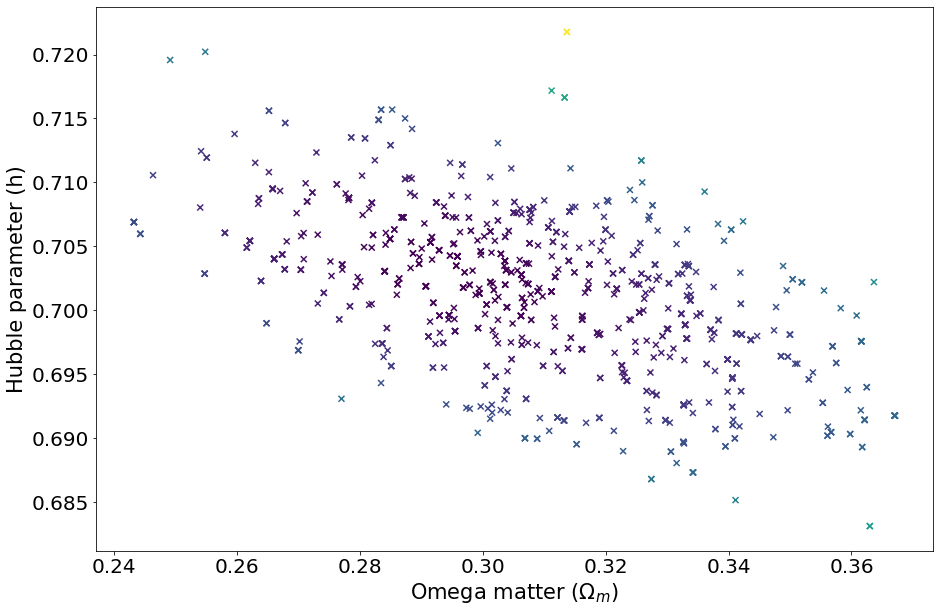

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(est_par[reject_samp:,0], est_par[reject_samp:,1], c=-est_par[reject_samp:,2], marker = 'x')
plt.xlabel('Omega matter ($\Omega_m$)', fontsize='21')
plt.ylabel('Hubble parameter (h)', fontsize='21')
#plt.grid()
#plt.savefig("burn-in scatter.pdf")

Plotting a histogram for different values of matter density paramater

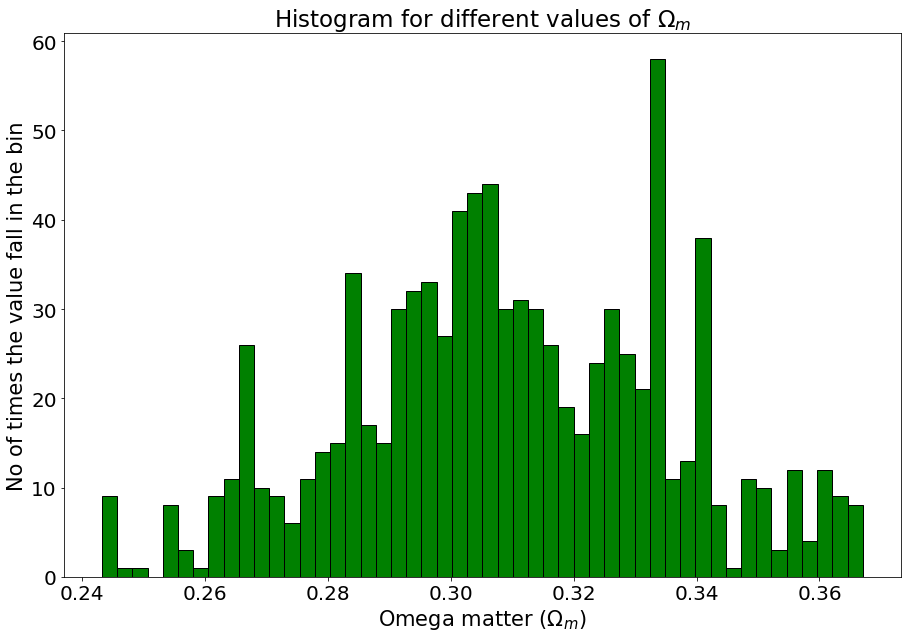

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(est_par[reject_samp:,0], edgecolor='black', bins=50, color = 'green')
plt.title('Histogram for different values of $\Omega_m$', fontsize='23')
plt.xlabel('Omega matter ($\Omega_m$)', fontsize='21')
plt.ylabel('No of times the value fall in the bin', fontsize='21')
#plt.grid()
#plt.savefig("omegam hist.pdf")

Plotting a histogram for different values of the hubble parameter vs count

Text(0, 0.5, 'No of times the value fall in the bin')

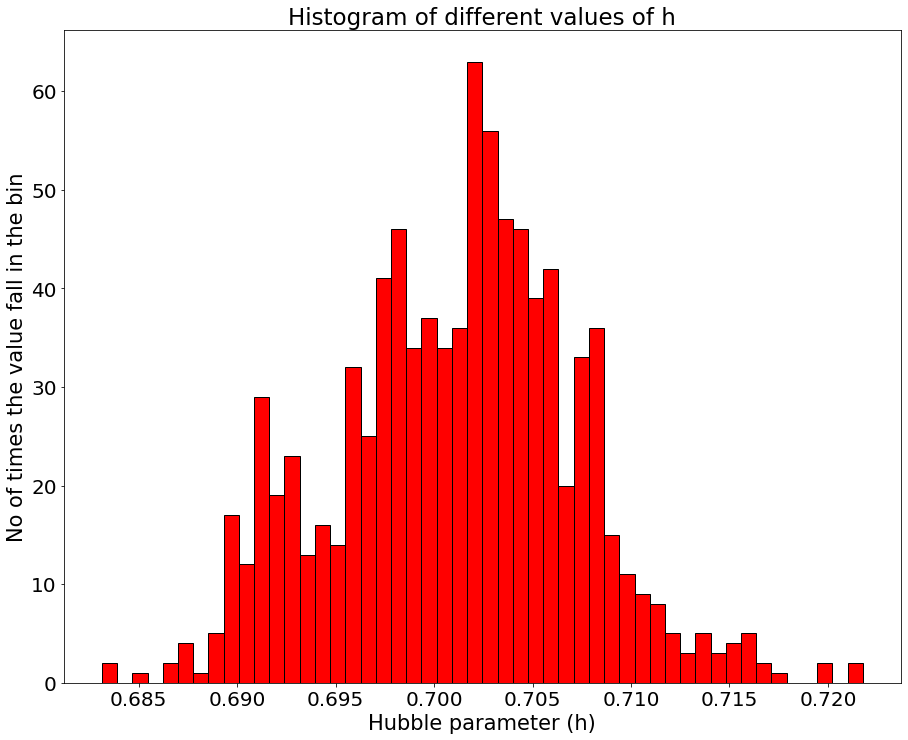

In [ ]:
plt.figure(figsize=(15,12))
plt.rcParams['font.size'] = 20
plt.hist(est_par[reject_samp:,1], edgecolor='black', bins=50, color = 'red')
plt.title('Histogram of different values of h', fontsize='23')
plt.xlabel('Hubble parameter (h)', fontsize='21')
plt.ylabel('No of times the value fall in the bin', fontsize='21')
#plt.grid()
#plt.savefig("hubble histogram.pdf")

We now calculate the theoritical values of distance modulus as a function of redshift from our estimation

In [ ]:
Myu_ith = np.empty(bins)
for i in range(bins):
    Myu_ith[i] = myu_ith(z[i],Ome_m,hp_m)

We compare the theoretically estimated data and the data we obtained by plotting them graphically, keeping redshift in the x-axis and the distance modulus in the y-axis

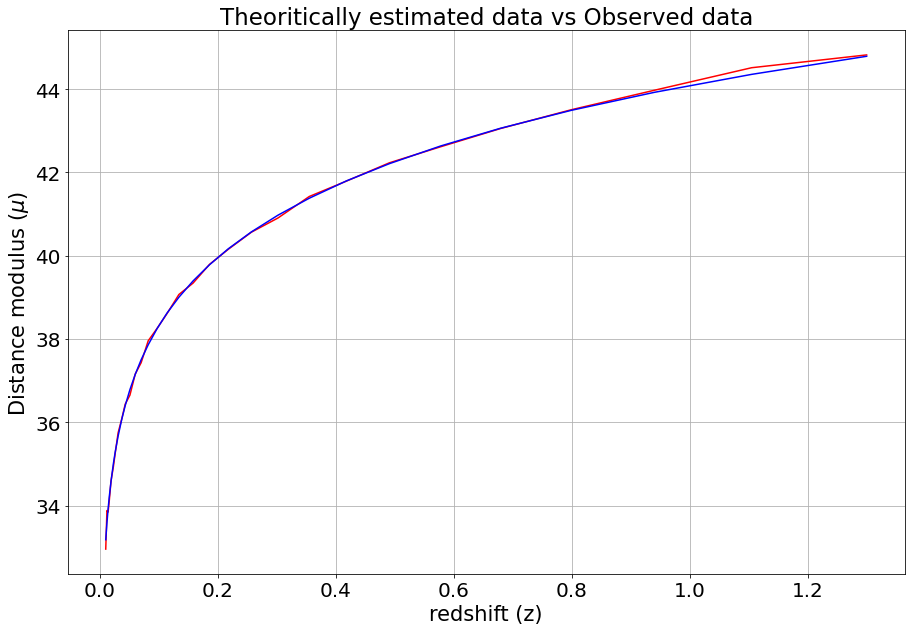

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(z, myu, label='Observed data',color ='red')
plt.plot(z, Myu_ith, label='Theoritically estimated data', color = 'blue')
plt.title('Theoritically estimated data vs Observed data', fontsize='23')
plt.xlabel('redshift (z)', fontsize='21')
plt.ylabel('Distance modulus ($\mu$)', fontsize='21')
plt.grid()
#plt.savefig("obs vs theory.pdf")